In [4]:
CURRENT_DIR = '../'
DET_THRESHOLD = 0.90
COS_THRESHOLD = 0.80
IMAGE_SIZE=112
N_JOBS=4
DATABASES = ['MELD', 'IEMOCAP', 'CAER', 'AFEW']

import os
from glob import glob
from tqdm.notebook import tqdm
import av
import numpy as np
import pickle
import random
from insightface.utils import face_align 
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import shutil
from joblib import Parallel, delayed



def video2numpy(path):
    container = av.open(path)
    frames = {}
    fps = round(float(container.streams.video[0].average_rate))
    
    for idx, frame in enumerate(container.decode(video=0)):
        numpy_RGB = np.array(frame.to_image())
        frames[idx] = numpy_RGB
    container.close()

    return frames, fps

def get_facepath(vidpath):
    facepath = None
    if '.mp4' in vidpath:
        facepath = vidpath.replace('raw-videos', 'faces').replace('.mp4', '.pkl')
    elif '.avi' in vidpath:
        facepath = vidpath.replace('raw-videos', 'faces').replace('.avi', '.pkl')
    return facepath

def load_face(facepath):
    with open(facepath, 'rb') as stream:
        face_dict = pickle.load(stream)
    return face_dict

def align_and_crop_faces(frame, face):
    faces_aligned = []
    for fc in face:
        img_aligned = face_align.norm_crop(frame, landmark=fc['landmark'], image_size=IMAGE_SIZE)
        faces_aligned.append(img_aligned)
    return faces_aligned

def get_unique_faces(embeddings_all, faces_aligned_all, blank_frames=True):
    

    X = [emb for embs in embeddings_all.values() for emb in embs]

    ac = AgglomerativeClustering(n_clusters=None, 
                                 affinity='cosine', 
                                 linkage='average',
                                 distance_threshold=COS_THRESHOLD)
    clustering = ac.fit(X)
    
    labels_unique = np.unique(clustering.labels_)

    vids = {lbl: np.zeros((len(embeddings_all), IMAGE_SIZE,IMAGE_SIZE,3), dtype=np.uint8) 
            for lbl in labels_unique}
    
    count = 0
    for frame_idx, faces_aligned in faces_aligned_all.items():
        for face_aligned in faces_aligned:
            lbl = clustering.labels_[count]
            vids[lbl][frame_idx] = face_aligned
            count+=1
            
    return vids

def save_face_videos(vids, vidpath, fps):
    
    dir_path = vidpath.replace('raw-videos', 'face-videos').split('.mp4')[0].split('.avi')[0]
    shutil.rmtree(dir_path, ignore_errors=True)
    os.makedirs(dir_path)
    
    for speaker_id in range(len(vids)):    
        save_full_path = os.path.join(dir_path, os.path.basename(dir_path)) + f"_{speaker_id:03d}.mp4"
        
        container = av.open(save_full_path, mode='w')

        stream = container.add_stream('mpeg4', rate=fps)
        stream.width = IMAGE_SIZE
        stream.height = IMAGE_SIZE

        for face in vids[speaker_id]:
            frame = av.VideoFrame.from_ndarray(face, format='rgb24')
            for packet in stream.encode(frame):
                container.mux(packet)
        # Flush stream
        for packet in stream.encode():
            container.mux(packet)

        # Close the file
        container.close()         

def batch_paths(all_vids_paths, n_jobs):
    batch_size = len(all_vids_paths) // n_jobs
    batched = [
        all_vids_paths[i*batch_size: (i+1)*batch_size] for i in range(n_jobs)]

    batched[-1] += all_vids_paths[batch_size*n_jobs:]

    assert sorted(all_vids_paths) == sorted(
        [bar for foo in batched for bar in foo])

    return batched
        
def run(videopaths):
    
    for vidpath in tqdm(videopaths):
        try:
            frames, fps = video2numpy(vidpath)
            facepath = get_facepath(vidpath)
            faces = load_face(facepath)

        except Exception as e:
            print(e)
            continue

        assert len(frames) == len(faces)

        indexes = list(frames.keys())

        faces_aligned_all = {}
        embeddings_all = {}
        for idx in indexes:
            frame = frames[idx]
            face = faces[idx]
            face = [fc for fc in face if fc['det_score'] > DET_THRESHOLD]
            faces_aligned = align_and_crop_faces(frame, face)
            faces_aligned_all[idx] = faces_aligned
            embeddings_all[idx] = [fc['normed_embedding'] for fc in face]

        assert len(frames) == len(faces) == len(faces_aligned_all) == len(embeddings_all)

        vids = get_unique_faces(embeddings_all, faces_aligned_all)

        for speaker_id, vid in vids.items():
            assert len(vid) == len(frames)

        save_face_videos(vids, vidpath, fps)
        
for DATABASE in tqdm(DATABASES):
    for DATASET in tqdm(['train', 'val', 'test']):
        videopaths = glob(os.path.join(CURRENT_DIR, DATABASE, 'raw-videos', DATASET, '*'))
        
        random.shuffle(videopaths)
        
        batched = batch_paths(videopaths, N_JOBS)
        
        
        Parallel(n_jobs=N_JOBS)(delayed(run)(batch) for batch in tqdm(batched))

KeyboardInterrupt: 

In [2]:
# vids.keys()

In [3]:
# from matplotlib import animation
# from IPython.display import HTML
# import matplotlib.pyplot as plt


# video = vids[0]

# def init():
#     im.set_data(video[0,:,:,:])

# def animate(i):
#     im.set_data(video[i,:,:,:])
#     return im

# # np array with shape (frames, height, width, channels)
# fig = plt.figure(figsize=(10,10))
# im = plt.imshow(video[0,:,:,:])

# plt.close() # this is required to not display the generated image


# anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
#                                interval=1/ fps * 1000)
# HTML(anim.to_html5_video())

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [5]:
for key, val in vids.items():
    print(key, len(val))

0 53


/home/tk/.virtualenvs/dev-python-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


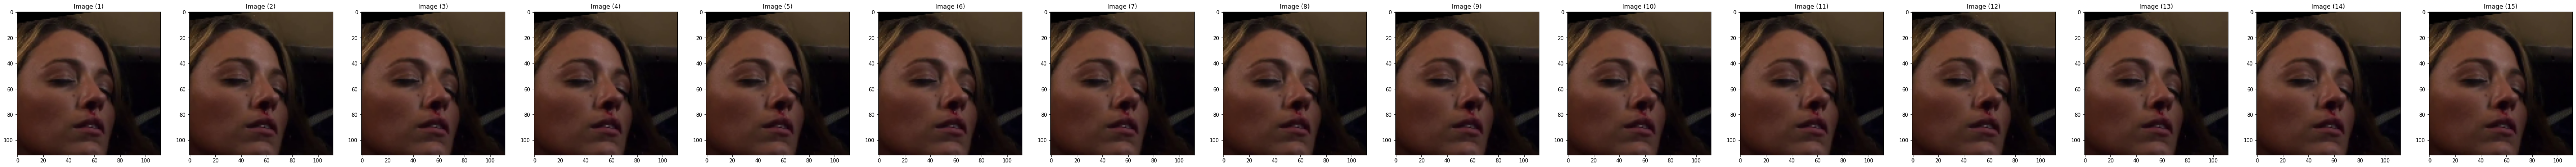

In [6]:
for key, val in vids.items():
    val = [v for v in val if v.sum() > 0]
    random.shuffle(val)
    show_images(val[:15], cols=1)